#Easy

# Step 1: Setup & Imports

In [2]:
!pip install --upgrade --quiet keras-nightly keras-hub-nightly

import numpy as np
import keras_hub
from keras_hub.utils import decode_imagenet_predictions
import PIL.Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

#Step 2: Load the image


10957/10957 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


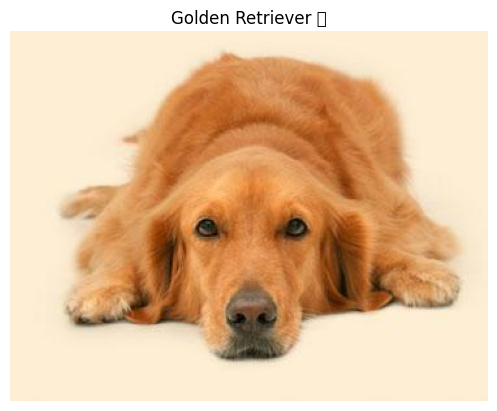

In [3]:
from keras import utils
import matplotlib.pyplot as plt
import keras_hub
import numpy as np

# ✅ Use a known-good image
image_url = "https://images.dog.ceo/breeds/retriever-golden/n02099601_100.jpg"
image_path = utils.get_file(origin=image_url)
image = utils.load_img(image_path)
plt.imshow(image)
plt.axis("off")
plt.title("Golden Retriever 🐶")
plt.show()


#Load Model and Predict Using keras_hub

In [4]:
# Load ResNet50 classifier from keras_hub
image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_50_imagenet",
    activation="softmax",
)

# Resize image and prepare batch
image_classifier.preprocessor.image_size = (224, 224)
image = image_classifier.preprocessor(image)
batch = np.array([image])

# Predict
preds = image_classifier.predict(batch)
print("Prediction shape:", preds.shape)


100%|██████████| 841/841 [00:00<00:00, 1.43MB/s]


100%|██████████| 3.59k/3.59k [00:00<00:00, 5.84MB/s]


100%|██████████| 98.1M/98.1M [00:07<00:00, 13.1MB/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction shape: (1, 1000)


#Step 4: understanding predictions


In [5]:
# Decode top-5 predictions
decode_imagenet_predictions(preds)


[[('matchstick', 0.010862592607736588),
  ('nematode', 0.009137322194874287),
  ('spotlight', 0.008445549756288528),
  ("jack-o'-lantern", 0.008324614726006985),
  ('digital_clock', 0.0076403929851949215)]]

#Intermediate

In [6]:
!pip install --upgrade --quiet keras-nightly keras-hub-nightly

#Import and Load the Model (Gemma 2B)

In [21]:
# prompt: load kaggle json  from local

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [23]:
import os
import shutil

# Create ~/.kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Replace '/content/kaggle.json' with the actual path to your uploaded 'kaggle.json' file
kaggle_json_path = "/content/kaggle.json"  # Update this path if needed

# Copy kaggle.json to the required location
shutil.copy(kaggle_json_path, "/root/.kaggle/kaggle.json")

# Set permission
os.chmod("/root/.kaggle/kaggle.json", 600)

print("✅ Kaggle credentials are set up from", kaggle_json_path)

import keras_hub

# Load Gemma 2B model (half-precision to save memory)
# Ensure you have the necessary permissions to access this model.
text_generator = keras_hub.models.CausalLM.from_preset(
    "gemma_2b_en",
    dtype="float16"
)

✅ Kaggle credentials are set up from /content/kaggle.json


#Run Text Generation

Story Prompt

In [24]:
template = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model"

question = """Tell a bedtime story about a robot who learned how to love. Keep it short and poetic."""

prompt = template.format(question=question)

response = text_generator.generate(
    prompt,
    max_length=512
)

print("Bedtime Story:\n")
print(response[0])

Bedtime Story:

<


#Advance level
fine tune and publish an image classifier

In [25]:
import tensorflow as tf
from tensorflow import keras
import keras_hub
import pathlib
import os

# ✅ Download and extract TF Flowers dataset
data_dir = keras.utils.get_file(
    "flower_photos",
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
)
data_dir = pathlib.Path(data_dir).parent / "flower_photos"


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [26]:
num_skipped = 0

for path in data_dir.rglob("*.jpg"):
    try:
        with open(path, "rb") as f:
            is_jfif = b"JFIF" in f.peek(10)
        if not is_jfif:
            num_skipped += 1
            os.remove(path)
    except Exception:
        continue  # skip unreadable files

print(f"Deleted {num_skipped}")


Deleted 6


In [27]:
# Step 3: Load dataset (crow vs dove)
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
)

Found 3664 files belonging to 1 classes.
Using 2932 files for training.
Using 732 files for validation.


In [28]:
# Step 4: Custom preprocessing pipeline
preprocessor = keras.layers.Pipeline([
    keras.layers.Rescaling(1.0 / 255),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
])

In [29]:
# Step 5: Load pretrained ResNet and customize for 2 classes
image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_50_imagenet",
    activation="softmax",
    num_classes=2,
    preprocessor=preprocessor,
)

In [30]:
# Step 6: Compile the model
image_classifier.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [31]:
# Step 7: Train the model
image_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 130s 801ms/step - accuracy: 0.9507 - loss: 0.3716 - val_accuracy: 1.0000 - val_loss: 0.0454
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 514ms/step - accuracy: 1.0000 - loss: 0.0337 - val_accuracy: 1.0000 - val_loss: 0.0130
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 457ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0057


In [32]:
# Step 8: Save to KerasHub-style preset
image_classifier.save_to_preset("bird_classifier_crow_vs_dove")

#Expert level

In [33]:
!pip install -q datasets

import keras
import keras_hub
import tensorflow as tf
from datasets import load_dataset
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [34]:
# Step 1: Load dataset from HuggingFace (no token needed)
dataset = load_dataset("ag_news", split="train[:2000]")  # Keep it small for demo
df = dataset.to_pandas()[["text", "label"]].dropna().reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [35]:
# Step 2: Split into train/val
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

In [36]:
# Step 3: Convert to tf.data.Dataset
def df_to_dataset(df, batch_size=2):
    return tf.data.Dataset.from_tensor_slices((df["text"].values, df["label"].values)).batch(batch_size)

raw_train_ds = df_to_dataset(train_df)
raw_val_ds = df_to_dataset(val_df)

In [37]:
# Step 4: Tokenizer + Backbone
tokenizer = keras_hub.tokenizers.Tokenizer.from_preset("bert_base_en")
backbone = keras_hub.models.Backbone.from_preset("bert_base_en")

100%|██████████| 457/457 [00:00<00:00, 239kB/s]


100%|██████████| 762/762 [00:00<00:00, 1.31MB/s]


100%|██████████| 208k/208k [00:00<00:00, 273kB/s]


100%|██████████| 414M/414M [00:28<00:00, 15.2MB/s]


In [38]:
# Step 5: Packer
packer = keras_hub.layers.StartEndPacker(
    start_value=tokenizer.start_token_id,
    end_value=tokenizer.end_token_id,
    pad_value=tokenizer.pad_token_id,
    sequence_length=256,
)

In [39]:
# Step 6: Preprocessing function
def preprocess(x, y=None, sequence_length=256):
    x = tokenizer(x)
    x = packer(x, sequence_length=sequence_length)
    x = {
        "token_ids": x,
        "padding_mask": x != tokenizer.pad_token_id,
    }
    return keras.utils.pack_x_y_sample_weight(x, y)

train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# 🧪 Peek
for batch in train_ds.take(1):
    print(batch)

({'token_ids': <tf.Tensor: shape=(2, 256), dtype=int32, numpy=
array([[  101, 12547, 19591, 11121,  1116,  1106, 11644,  2875, 13411,
         2249,   143,  9664, 15517,  6258, 15678,   113, 11336, 27603,
          114,   118, 12547, 19591,  3561,   119,   111,   181,  1204,
          132,   138,   145, 16941,  2271,   134,   107,  8413,   131,
          120,   120,  7001,   119, 16321,   119,  1231, 27603,   119,
         3254,   120,  8896,  4880, 11848,  1566,   119,  1112,  1643,
         1775,   136,   189, 23666,   134,  6586, 13821,   119,   152,
         4010,   134,   120, 17901,   120,  3613,  1394, 14467,   120,
         1554,  4426, 11848,  1566,   107,   111,   176,  1204,   132,
         6586, 13821,   119,   152,   111,   181,  1204,   132,   120,
          138,   111,   176,  1204,   132,   117,  1103,  2026, 11166,
         1104, 11451,   118,  1543,  5537,   117,  1113,  9667,  1163,
         8071,  5369,  1113,  1207,  3533, 21236, 11615,  1167,  1190,
        11590,

In [40]:
from keras import layers, Model, Input

# Step 1: Inputs
inputs = {
    "token_ids": Input(shape=(256,), dtype="int32"),
    "padding_mask": Input(shape=(256,), dtype="bool"),
    "segment_ids": Input(shape=(256,), dtype="int32"),
}

# Step 2: Pass to Gemma2 backbone — returns a dict
x = backbone(inputs)

# Step 3: Use sequence_output (batch_size, sequence_len, hidden_dim)
x = x["sequence_output"]

# Step 4: Pool + classify
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)

# Step 5: Final model
model = Model(inputs, outputs)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'token_ids' mapping to value <KerasTensor shape=(None, 256), dtype=int32, sparse=False, ragged=False, name=keras_tensor_408> which has name 'keras_tensor_408'. Change the tensor name to 'token_ids' (via `Input(..., name='token_ids')`)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'padding_mask' mapping to value <KerasTensor shape=(None, 256), dtype=bool, sparse=False, ragged=False, name=keras_tensor_409> which has name 'keras_tensor_409'. Change the tensor name to 'padding_mask' (via `Input(..., name='padding_mask')`)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py

In [41]:
x = backbone(inputs)
x = x["pooled_output"]  # BERT [CLS] embedding
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)  # 4 classes in AG News

model = Model(inputs, outputs)


In [42]:
def preprocess(x, y=None, sequence_length=256):
    x_tokenized = tokenizer(x)
    x_packed = packer(x_tokenized, sequence_length=sequence_length)

    inputs = {
        "token_ids": x_packed,
        "padding_mask": x_packed != tokenizer.pad_token_id,
        "segment_ids": tf.zeros_like(x_packed),  # BERT needs this
    }

    return keras.utils.pack_x_y_sample_weight(inputs, y)



In [43]:
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [44]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 186s 148ms/step - accuracy: 0.5363 - loss: 1.1759 - val_accuracy: 0.5375 - val_loss: 0.8973
Epoch 2/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 116s 144ms/step - accuracy: 0.5019 - loss: 1.1512 - val_accuracy: 0.3825 - val_loss: 1.3817
Epoch 3/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 114s 143ms/step - accuracy: 0.3011 - loss: 1.5299 - val_accuracy: 0.3825 - val_loss: 1.3743
